# Apply HDBSCAN, KMeans to get the cluster for Non-Null Attributes 
  - Module name: Cluster_Attribute_Distance_hdb_kmeans.ipynb
    - Cloned from Cluster_Attribute_Distance_081423.ipynb written by Shiladitya and made the following modification 
  - input: Cluster_Non_Null_Attribs_081523.csv with shape = (7158, 4) and columns below
    - ClusterLabel        
    - Cluster Name        
    - Cluster Size        
    - Non-Null Attributes 
  
  - Functionality
    1. Get all attributes by tokenized items in 'Non-Null Attributes' and create a set 'all_attrbs'
      - apply "ast.literal_eval(x)" to convert 'Non-Null Attributes' to a list apply sum() to tokenize
      - apply set to dedupe
      - len(all_attrbs) = 221from input
    2. Inter cluster overlap
      - Define function cluster_attribute_overlap(clustid_1, clustid_2) to calculate inter cluster overlap  betwen two rows 
      - Create a DF 'clust_attrb_similarity' with column 'Similarity_Ref' 
      - For all rows, invoke cluster_attribute_overlap to calulate overlap between the row and row 10.
      - Apply  plotly and non- plotly to draw histogram for Similarity_Ref
    3. Define a function "get_attribute_dict(clust_attrbs) to build a dictionary
      - Scan items in all_attrbs and check if the item in clust_attrbs and  build a dictionary
        - Key: attribute from all_attrbs
        - value
        - 0 : if key is not in clust_attrbs
        - 1 : if key is in clust_attrbs
       - Invoke 'get_attribute_dict' with parameter as 'Non-Null Attributes' and build a dictionary
         - Based on the values from dictionary to create clust_attr['AttributeVector']
            - Key: attribute from all_attrbs
            - value 
                - 0 : if key is not in clust_attr['Non-Null Attributes']
                - 1 : if key is in clust_attr" ['Non-Null Attributes']
          - Based on the values from dictionary to create clust_attr['AttributeVector']
            - a list of  len = 221 with value 0 or 1
    4. Build models   
          - Create a list of attr_vects by  extracting values from clust_attr.AttributeVector
          - Apply HDBSCAN to fit attr_vects
            - Add a new column 'kmeans_cluster' into clust_attr to save 'means.labels_ 
            - Add a new column 'kmeans_clust_desc' into clust_attr by mapping kmeans_cluster to description specified in list(all_attrbs)
          - Apply KMeans to fit attr_vects 
            - Add a new column 'kmeans_cluster' into clust_attr to save 'means.labels_ 
            - Add a new column 'kmeans_clust_desc' into clust_attr by mapping kmeans_cluster to a description specified in list(all_attrbs)
    5. Plot for clustering
       - Apply TSNE to convert attr_vects into array X_embedded with two components.
       - For the columns 'hdb_cluster', 'hdb_clust_desc', 'kmeans_cluster', 'kmeans_clust_desc'] 
         - Apply sns.scatterplot   
         - Apply plotly scatter 
           - Construct df_tsne with columns below for plotly scatter 
             - 'x' 'y' 'hdb_cluster' 'hdb_clust_desc' 'kmeans_cluster'
                - 'x' is the first component of X_embedded
                - 'x' is the second component of X_embedded
    6. Save the CSV file 'hdb_kmeans_ClusteringResults_mmddyy.csv'
    
  - Author: Sophia Yue
  - Date: 09-19-23
  - Notes:  The scikit-learn  version  3.1 is required to run HDBCSAN 
    - Install most current version 1.3.0 for scikit-learn to run HDBCSAN
     - from Jupyter  
       - run 'sklearn.__version__' to get scikit-learn version 
       - run '!pip install --upgrade scikit-learn' to install scikit earn
     - from command       
       - run 'pip3 show scikit-learn' to get scikit-learn version 
       - run 'pip3 install --upgrade scikit-learn' to install scikit earn

In [ ]:
 needs to run 

In [3]:
import pandas as pd, numpy as np
import ast
from sklearn.cluster import HDBSCAN, KMeans

pd.set_option("display.max_rows", None)
pd.set_option("display.max_column", None)

In [4]:
path = 'C:\\users\\iny2819\\kroger\\Data\\' 
clust_attr = pd.read_csv(path + 'Cluster_Non_Null_Attribs_081523.csv') # (7158, 4)
clust_attr.info()

In [8]:
clust_attr.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7158 entries, 0 to 7157
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ClusterLabel         7158 non-null   int64 
 1   Cluster Name         7158 non-null   object
 2   Cluster Size         7158 non-null   int64 
 3   Non-Null Attributes  7158 non-null   object
dtypes: int64(2), object(2)
memory usage: 223.8+ KB


ClusterLabel                                       Cluster Name  \
0             0  PARTY EVERYDAY,NOVELTY AND DECOR,GIFT-WRAP SEA...   
1             1  ACCENT FURNITURE,KITCHEN/DINING,DECORATIVE ACC...   
2             2  TEA BAGS & BULK TEA,TEA SWEETENED,TEA BAGS/HER...   
3             3                                     CARDS EVERYDAY   
4             4  COLD WEATHER ACS,BRANDED COLLECTIONS,JUNIOR SL...   

   Cluster Size                                Non-Null Attributes  
0          1306  ['Color', 'Size Description', 'Other Size Desc...  
1          1145  ['Genre', 'Color', 'Size Description', 'Other ...  
2          1086  ['Method of Sweetening', 'Level of Sugar/Sucro...  
3          1085  ['VND_BRN_NAM', 'NET_CONT_EQV_UOM_VIP_TO_KRG_U...  
4           991  ['Color', 'Size Description', 'Other Size Desc...

In [4]:
clust_attr.tail()

ClusterLabel                                       Cluster Name  \
7153          7154        MARIKA CURVES,MARIKA,4-16 BOTTOMS,SNACK MIX   
7154          7155           DVD'S,PUZZLES,GIFT-WRAP EVERYDAY,LAUNDRY   
7155          7156  NCAA OTHER,PHARMACY SUPPLIES,OTHER EVENTS,MARI...   
7156          7157           DIY ELECTRICAL,WORK LIGHTS,WATER BOTTLES   
7157          7158                                 LAMPS,SHADES/BASES   

      Cluster Size                                Non-Null Attributes  
7153            10  ['MIN_DAYS_OF_SHF_LIF_AT_WHS_DAYS', 'NET_CONT_...  
7154            10  ['Genre', 'Color', 'Size Description', 'Consum...  
7155            10  ['Color', 'Size Description', 'Other Size Desc...  
7156            10  ['Color', 'LIV_NAT_ELG_FL', 'ALH_FL', 'IS_EDBL...  
7157            10  ['VND_BRN_NAM', 'NET_CONT_EQV_UOM_VIP_TO_KRG_U...

### Inter-Cluster Attribute Overlap

##  Get all attributes
  - apply "ast.literal_eval(x)" to convert 'Non-Null Attributes' to a list
  - apply sum() to tokennize  
    - sum() can't apply to list alone
    - sum() needs to come after lambda
  -  apply set to dedupe  
  - len(all_attrbs) = 221

In [6]:
#import ast
all_attrbs = set(clust_attr['Non-Null Attributes'].apply(lambda x: ast.literal_eval(x)).sum())  # type set
all_attrbs

In [13]:
all_attrbs

{'1,3-Bis-(2,4-diaminophenoxy)propane',
 '1-Naphthol',
 '2 (4-tert-Butylbenzyl)',
 '2,5-Diaminotoluene',
 '2,6-Dimethoxy-3,5-pyridinediamine HCl',
 '2-Methyl-5-hydroxyethylaminophenol',
 '3-Aminophenol',
 '4-Amino-3-nitrophenol',
 '4-Hydroxy-propylamino-3-nitrophenol',
 'ALH_FL',
 'ASBD_ACU_PDT_HGT_IN_INCH',
 'ASBD_ACU_PDT_LTH_IN_INCH',
 'ASBD_ACU_PDT_WGT_IN_LBS',
 'ASBD_ACU_PDT_WTH_IN_INCH',
 'ASB_REQ_VLU',
 'ATI_TIP_KIT_ICD_VLU',
 'AVG_WTTG_VLU',
 'Age Restricted',
 'Alcohol Proof',
 'Almond and Almond Products',
 'Alpha-Isomethyl Ionone',
 'Amyl Cinnamal',
 'Amylcinnamyl Alcohol',
 'Anchovy and its Derivatives',
 'Anise Alcohol',
 'Apple and its derivatives',
 'Artist',
 'BPA_FRE_VLU',
 'BRD_ANM_TYP_VLU',
 'BTR_ICD_VLU',
 'BTR_REQ_VLU',
 'BTR_TYP_VLU',
 'Banner Name',
 'Barley and Barley Products',
 'Barnacle and its Derivatives',
 'Beef and its Derivatives',
 'Benzyl Alcohol',
 'Benzyl Benzoate',
 'Benzyl Cinnamate',
 'Benzyl Salicylate',
 'Boneless Claim',
 'Brazil Nut and Brazil 

In [6]:
len(all_attrbs)

221

In [50]:
#Inter cluster overlap
def cluster_attribute_overlap(clustid_1, clustid_2):
    att1 = set(clust_attr.iloc[[clustid_1]]['Non-Null Attributes'].apply(lambda x: ast.literal_eval(x)).sum())
    att2 = set(clust_attr.iloc[[clustid_2]]['Non-Null Attributes'].apply(lambda x: ast.literal_eval(x)).sum())
    overlap = att1.intersection(att2)
    return len(overlap)/(np.sqrt(len(att1))*np.sqrt(len(att2)))
    

In [51]:
cluster_attribute_overlap(1,0)

0.7437357441610946

In [52]:
ref_clust_ix = 10
row = clust_attr.iloc[ref_clust_ix]
print(row['Cluster Name'])

SANDWICH COOKIES,COOKIES: HOLIDAY/SPECIAL OCCASIONS,COOKIES/SWEET GOODS,COOKIES: REGULAR


In [53]:
clust_attrb_similarity = pd.DataFrame(columns= ['ClusterLabel','ClusterName','Similarity_Ref'])
for i in range(len(clust_attr)):
    row = clust_attr.iloc[i]
    #print(row['ClusterLabel'],row['Cluster Name'], cluster_attribute_overlap(7,i))
    clust_attrb_similarity.loc[len(clust_attrb_similarity)] = [row['ClusterLabel'],row['Cluster Name'],   \
                                                               cluster_attribute_overlap(ref_clust_ix,i)]
clust_attrb_similarity.sort_values('Similarity_Ref', ascending = False, inplace = True)  
clust_attrb_similarity[clust_attrb_similarity.Similarity_Ref >0.8].head(10)

In [54]:
clust_attrb_similarity.sort_values('Similarity_Ref', ascending = False, inplace = True)

In [55]:
clust_attrb_similarity[clust_attrb_similarity.Similarity_Ref >0.8].head(50)

ClusterLabel                                        ClusterName  \
10             10  SANDWICH COOKIES,COOKIES: HOLIDAY/SPECIAL OCCA...   
7               7  CAKES: CUPCAKES,CAKES: LAYERS,CAKES: SHEET,CAK...   
119           119  POPCORN - MICROWAVE,BAGGED POPPED POPCORN,POPC...   
250           250  INSTANT OATMEAL,STANDARD OATMEAL,CEREAL - HOT,...   
17             17        BONNE BELL,NYX,PASSOVER PRODUCTS,MAYBELLINE   
13             13             BBQ SAUCE,MAINSTREAM,PREMIUM,HOT SAUCE   
2               2  TEA BAGS & BULK TEA,TEA SWEETENED,TEA BAGS/HER...   
155           155  CANDY BAGS-CHOCOLATE,CANDY BAGS-NON CHOCOLATE,...   
31             31  GREEK SS YOGURT,TRADITIONAL SS YOGURT,KIDS YOG...   
262           262  PRETZELS,CANDY BAGS-CHOCOLATE W/FLOUR,SWEET GO...   
72             72  TOMATOES DICED,VEGETABLE,TOMATO SAUCE,VEGETABL...   
44             44  EGG COLORING/FILL,EGGS - LARGE,EASTER GIFTWARE...   
89             89  BREAKFAST SWEETS: MUFFINS,WAFFLES/PANCAKES/FRE...   
45             45  PREMIUM,TRADITIONAL,SUPER PREMIUM PINTS,NF ICE...   
108           108  POURABLE SALAD DRESSINGS,DRY SALAD DRESSING&DI...   
56             56  PIZZA/PREMIUM,PIZZA/TRADITIONAL,PIZZA/ECONOMY,...   
115           115  PREMIUM BREAD,MAINSTREAM WHITE BREAD,NF BAKED ...   
171           171  POTATOES: DRY,POTATOES RUSSET (BULK&BAG),POTAT...   
213           213           CORN,CORNMEAL,GADGETS/TOOLS,CORN ORGANIC   
376           376           ALMONDS,NUTS,BAKING NUTS,ALMONDS SHELLED   
87             87  SHREDDED CHEESE,SPECIALTY BULK CHEESE CHEDDAR ...   
51             51  VEG/GRAIN/PASTA SALADS,PROTEIN SALADS,FK GREEN...   
415           415  MUSHROOMS CND & GLASS,MUSHROOMS DRIED,MUSHROOM...   
48             48  READY TO SERVE,CONDENSED SOUP,NF READY TO SERV...   
35             35  VARIETY BEANS - KIDNEY/PINTO/ETC,DRY BEANS/PEA...   
148           148  GREEN OLIVES,SPECIALTY OLIVES,RIPE OLIVES,SAL:...   
59             59              TRAIL MIX,PEANUTS ALL,NUTS,MIXED NUTS   
512           512  BREAKFAST SWEETS: DONUTS,DONUTS - BOXED,DONUTS...   

     Similarity_Ref  
10         1.000000  
7          0.909416  
119        0.878638  
250        0.859990  
17         0.852679  
13         0.848537  
2          0.845315  
155        0.842378  
31         0.841969  
262        0.841969  
72         0.835191  
44         0.834523  
89         0.832050  
45         0.831220  
108        0.829249  
56         0.829005  
115        0.823218  
171        0.819513  
213        0.814174  
376        0.813173  
87         0.811540  
51         0.811503  
415        0.810476  
48         0.805156  
35         0.805156  
148        0.804495  
59         0.803802  
512        0.803739

<Axes: >

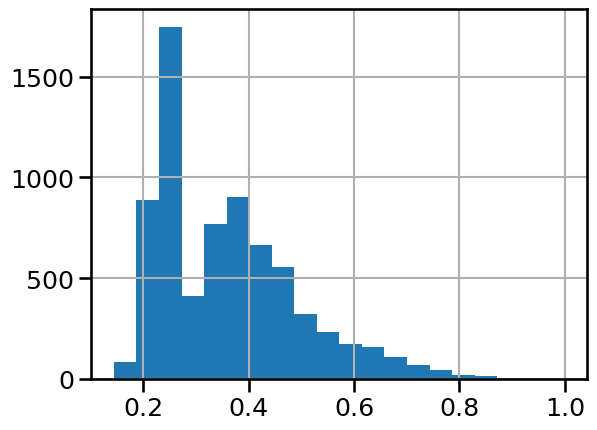

In [56]:
clust_attrb_similarity.Similarity_Ref.hist(bins = 20)

In [59]:
import plotly.express as px
fig = px.histogram(clust_attrb_similarity, x="Similarity_Ref", nbins=20)
fig.show()

In [60]:
import plotly.express as px
fig = px.histogram(clust_attrb_similarity, x="Similarity_Ref")
fig.show()

In [58]:
clust_attrb_similarity.tail()

ClusterLabel                                        ClusterName  \
3016          3016                                    ASSORTED GARDEN   
6826          6827           PLANT STANDS & ACCESSORIES,DECOR PILLOWS   
5937          5938                                       SALLY HANSEN   
4721          4721  SUNTAN FACIAL LOTION/STICK,SUNTAN LOTION,SUNTA...   
4993          4993                  MAYBELLINE,ALMAY,LOREAL COSMETICS   

      Similarity_Ref  
3016        0.176777  
6826        0.176777  
5937        0.144338  
4721        0.144338  
4993        0.144338

### Attribute Binary Vectors
   - Build a dictionary 
     - Scan item in all_attrbs
     - Key: attribute from all_attrbs
     - value
       - 0 : if key  is not in Scan item/token clust_attr['Non-Null Attributes']
       - 1 : Scan item/token clust_attr['Non-Null Attributes']
   - Based on the values from dictionary to create clust_attr['AttributeVector']     
     - a list with len = 221

In [8]:
def get_attribute_dict(clust_attrbs):
    return {i: int(i in clust_attrbs) for i in all_attrbs}

In [12]:
clust_attr[clust_attr.ClusterLabel == 200]['Non-Null Attributes']

200    ['Genre', 'Color', 'Size Description', 'Other ...
Name: Non-Null Attributes, dtype: object

In [13]:
get_attribute_dict(clust_attr['Non-Null Attributes'].iloc[200]) # len 221

{'Seed Products': 0,
 'Mango and its derivatives': 0,
 'Sesame Seeds and Their Derivatives': 0,
 'Harvest Type': 0,
 'INE_USE_OF_PDT_TX': 1,
 '1-Naphthol': 0,
 'BTR_REQ_VLU': 0,
 'Benzyl Alcohol': 0,
 'KRG_OWN_IS_RAW_VLU': 0,
 'Card Reloadable': 0,
 'Pine Nut and Their Derivatives': 0,
 'Cocoa and its Derivatives': 0,
 'Geraniol': 0,
 'Molluscs and Their Derivatives': 0,
 'Diaminophenols': 0,
 'Flavor(s)': 0,
 'Hickory Nuts and Their Derivatives': 0,
 'Sold only at Kroger Fuel Centers': 0,
 'Pollock and its Derivatives': 0,
 'Hydroxyisohexyl 3-Cyclohexene Carboxaldehyde': 0,
 'Milk Product/Substitute': 0,
 'Size Description': 1,
 '2,5-Diaminotoluene': 0,
 'ASBD_ACU_PDT_HGT_IN_INCH': 1,
 'Citronellol': 0,
 'Card Is Closed Loop': 0,
 'Herring and its Derivatives': 0,
 'KRG_OWN_IS_CHEM_VLU': 0,
 'FIN_VLU': 0,
 'Pecan Nut and Pecan Nut Products': 0,
 'Type of Spirit': 0,
 'Crustaceans and Their Derivatives': 0,
 'Peanuts and Their Derivatives': 0,
 'Glutamate and Their Derivatives': 0,
 'T

In [27]:
len(get_attribute_dict(clust_attr['Non-Null Attributes'].iloc[200]))

221

In [9]:
clust_attr['AttributeVector'] = clust_attr['Non-Null Attributes'].apply(lambda x: list(get_attribute_dict(x).values()))

In [15]:
len(clust_attr)

7158

In [16]:
clust_attr.head()

ClusterLabel                                       Cluster Name  \
0             0  PARTY EVERYDAY,NOVELTY AND DECOR,GIFT-WRAP SEA...   
1             1  ACCENT FURNITURE,KITCHEN/DINING,DECORATIVE ACC...   
2             2  TEA BAGS & BULK TEA,TEA SWEETENED,TEA BAGS/HER...   
3             3                                     CARDS EVERYDAY   
4             4  COLD WEATHER ACS,BRANDED COLLECTIONS,JUNIOR SL...   

   Cluster Size                                Non-Null Attributes  \
0          1306  ['Color', 'Size Description', 'Other Size Desc...   
1          1145  ['Genre', 'Color', 'Size Description', 'Other ...   
2          1086  ['Method of Sweetening', 'Level of Sugar/Sucro...   
3          1085  ['VND_BRN_NAM', 'NET_CONT_EQV_UOM_VIP_TO_KRG_U...   
4           991  ['Color', 'Size Description', 'Other Size Desc...   

                                     AttributeVector  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...

In [10]:
#from sklearn.cluster import HDBSCAN, KMeans
attr_vects = [i for i in clust_attr.AttributeVector]

In [82]:
type(attr_vects )

list

In [1]:
import sklearn
sklearn.__version__

'1.3.0'

In [18]:
all_attrbs_bkup = all_attrbs.copy()

In [20]:
clust_attr = clust_attr.copy() 

In [11]:
hdb = HDBSCAN(min_cluster_size= 5)hdb.fit(attr_vects)
hdb.fit(attr_vects)

In [12]:
kmeans = KMeans(n_clusters= 50, random_state=0, n_init="auto").fit(attr_vects)

In [13]:
hdb.fit(attr_vects)

HDBSCAN()

In [29]:
clust_attr['kmeans_cluster'] = kmeans.labels_ 
clust_attr['kmeans_clust_desc'] = clust_attr['kmeans_cluster'].apply( lambda x : 'Ignore' if x == -1 else list(all_attrbs)[x])
clust_attr.head() 

ClusterLabel                                       Cluster Name  \
0             0  PARTY EVERYDAY,NOVELTY AND DECOR,GIFT-WRAP SEA...   
1             1  ACCENT FURNITURE,KITCHEN/DINING,DECORATIVE ACC...   
2             2  TEA BAGS & BULK TEA,TEA SWEETENED,TEA BAGS/HER...   
3             3                                     CARDS EVERYDAY   
4             4  COLD WEATHER ACS,BRANDED COLLECTIONS,JUNIOR SL...   

   Cluster Size                                Non-Null Attributes  \
0          1306  ['Color', 'Size Description', 'Other Size Desc...   
1          1145  ['Genre', 'Color', 'Size Description', 'Other ...   
2          1086  ['Method of Sweetening', 'Level of Sugar/Sucro...   
3          1085  ['VND_BRN_NAM', 'NET_CONT_EQV_UOM_VIP_TO_KRG_U...   
4           991  ['Color', 'Size Description', 'Other Size Desc...   

                                     AttributeVector  hdb_cluster  \
0  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1   
1  [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1   
2  [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...           -1   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...          113   
4  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1   

                hdb_clust_desc  kmeans_cluster  \
0                       Ignore              35   
1                       Ignore              25   
2                       Ignore              16   
3  Tilapia and its Derivatives              20   
4                       Ignore              42   

                   kmeans_clust_desc  
0                 METHYL 2-OCTYNOATE  
1  Pot/Planter Size - Liquid Measure  
2                        SRV_CNT_VLU  
3            Milk Product/Substitute  
4                             Rating

In [21]:
clust_attr['hdb_cluster'] = hdb.labels_ 
clust_attr.head() 

ClusterLabel                                       Cluster Name  \
0             0  PARTY EVERYDAY,NOVELTY AND DECOR,GIFT-WRAP SEA...   
1             1  ACCENT FURNITURE,KITCHEN/DINING,DECORATIVE ACC...   
2             2  TEA BAGS & BULK TEA,TEA SWEETENED,TEA BAGS/HER...   
3             3                                     CARDS EVERYDAY   
4             4  COLD WEATHER ACS,BRANDED COLLECTIONS,JUNIOR SL...   

   Cluster Size                                Non-Null Attributes  \
0          1306  ['Color', 'Size Description', 'Other Size Desc...   
1          1145  ['Genre', 'Color', 'Size Description', 'Other ...   
2          1086  ['Method of Sweetening', 'Level of Sugar/Sucro...   
3          1085  ['VND_BRN_NAM', 'NET_CONT_EQV_UOM_VIP_TO_KRG_U...   
4           991  ['Color', 'Size Description', 'Other Size Desc...   

                                     AttributeVector  hdb_cluster  
0  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1  
1  [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1  
2  [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...           -1  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...          113  
4  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1

In [23]:
clust_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7158 entries, 0 to 7157
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ClusterLabel         7158 non-null   int64 
 1   Cluster Name         7158 non-null   object
 2   Cluster Size         7158 non-null   int64 
 3   Non-Null Attributes  7158 non-null   object
 4   AttributeVector      7158 non-null   object
 5   hdb_cluster          7158 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 335.7+ KB


In [26]:

clust_attr['hdb_clust_desc'] = clust_attr['hdb_cluster'].apply( lambda x : 'Ignore' if x == -1 else list(all_attrbs)[x])
clust_attr.head(2)

ClusterLabel                                       Cluster Name  \
0             0  PARTY EVERYDAY,NOVELTY AND DECOR,GIFT-WRAP SEA...   
1             1  ACCENT FURNITURE,KITCHEN/DINING,DECORATIVE ACC...   

   Cluster Size                                Non-Null Attributes  \
0          1306  ['Color', 'Size Description', 'Other Size Desc...   
1          1145  ['Genre', 'Color', 'Size Description', 'Other ...   

                                     AttributeVector  hdb_cluster  \
0  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1   
1  [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1   

  hdb_clust_desc  
0         Ignore  
1         Ignore

In [28]:
clust_attr.head(10)

ClusterLabel                                       Cluster Name  \
0             0  PARTY EVERYDAY,NOVELTY AND DECOR,GIFT-WRAP SEA...   
1             1  ACCENT FURNITURE,KITCHEN/DINING,DECORATIVE ACC...   
2             2  TEA BAGS & BULK TEA,TEA SWEETENED,TEA BAGS/HER...   
3             3                                     CARDS EVERYDAY   
4             4  COLD WEATHER ACS,BRANDED COLLECTIONS,JUNIOR SL...   
5             5  PLANT STANDS & ACCESSORIES,WALL ART,NOVELTY AN...   
6             6                          CARDS EVERYDAY,CARD GAMES   
7             7  CAKES: CUPCAKES,CAKES: LAYERS,CAKES: SHEET,CAK...   
8             8  HOME OFFICE,ACCENT FURNITURE,KITCHEN ACCESSORI...   
9             9  BOISE STATE UNIVERSITY,OSU COLLEGIATE,UO COLLE...   

   Cluster Size                                Non-Null Attributes  \
0          1306  ['Color', 'Size Description', 'Other Size Desc...   
1          1145  ['Genre', 'Color', 'Size Description', 'Other ...   
2          1086  ['Method of Sweetening', 'Level of Sugar/Sucro...   
3          1085  ['VND_BRN_NAM', 'NET_CONT_EQV_UOM_VIP_TO_KRG_U...   
4           991  ['Color', 'Size Description', 'Other Size Desc...   
5           938  ['Color', 'ASBD_ACU_PDT_HGT_IN_INCH', 'ASBD_AC...   
6           909  ['VND_BRN_NAM', 'NET_CONT_EQV_UOM_VIP_TO_KRG_U...   
7           841  ['Method of Sweetening', 'Level of Sugar/Sucro...   
8           844  ['Color', 'Size Description', 'Other Color', '...   
9           830  ['Color', 'Size Description', 'Other Size Desc...   

                                     AttributeVector  hdb_cluster  \
0  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1   
1  [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1   
2  [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...           -1   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...          113   
4  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1   
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           32   
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...          113   
7  [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, ...           -1   
8  [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1   
9  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...           -1   

                hdb_clust_desc  
0                       Ignore  
1                       Ignore  
2                       Ignore  
3  Tilapia and its Derivatives  
4                       Ignore  
5       Other Size Description  
6  Tilapia and its Derivatives  
7                       Ignore  
8                       Ignore  
9                       Ignore

In [15]:
hdb.labels_  #array([ -1,  -1,  -1, ...,  35,  86, 127], dtype=int64); numpy.ndarray
type(hdb.labels_)  #array([ -1,  -1,  -1, ...,  35,  86, 127], dtype=int64)

numpy.ndarray

In [30]:
pd.Series(kmeans.labels_).value_counts(dropna = False).sort_index() 

0     1316
1      294
2       54
3       44
4      101
5       85
6      181
7       36
8      114
9      107
10     382
11     133
12     267
13      96
14      61
15     729
16      39
17     111
18     308
19      78
20     312
21      94
22      27
23      60
24      19
25      40
26     112
27     169
28     248
29     109
30      54
31      88
32      41
33      42
34      20
35      61
36     178
37      55
38      55
39     223
40      48
41      54
42      95
43      19
44      51
45      68
46      64
47      10
48      81
49     125
dtype: int64

In [17]:
pd.Series(hdb.labels_).value_counts(dropna = False).sort_index() 

-1      2784
 0         5
 1         8
 2         7
 3         6
 4         6
 5        32
 6         5
 7        15
 8         6
 9        18
 10        7
 11        6
 12       11
 13       16
 14       31
 15       68
 16       10
 17       61
 18       10
 19       11
 20        8
 21        6
 22       48
 23        8
 24       15
 25       20
 26       13
 27       11
 28       16
 29        6
 30       39
 31       10
 32       29
 33        8
 34       13
 35        7
 36        5
 37       13
 38       11
 39        5
 40        5
 41       12
 42        8
 43       25
 44        5
 45       12
 46        8
 47        5
 48       56
 49        6
 50        5
 51       45
 52       32
 53        7
 54       71
 55       14
 56       70
 57        6
 58       16
 59        5
 60       16
 61       46
 62        9
 63        6
 64        7
 65       32
 66       13
 67        8
 68        5
 69       13
 70       31
 71       26
 72       75
 73       17
 74       19
 75       25

In [22]:
pd.Series(hdb.labels_).value_counts().sort_values(ascending = False)

-1      2784
 123    1060
 82      592
 93      155
 127     144
        ... 
 129       5
 125       5
 36        5
 47        5
 114       5
Length: 133, dtype: int64

In [23]:
clust_attr['SuperCluster Label'] = hdb.labels_

In [24]:
clust_attr['KMeans SuperCluster Label'] = kmeans.labels_

In [64]:
clust_attr['KMeans SuperCluster Label'].value_counts()

0     1316
15     729
10     391
18     312
20     312
1      288
12     275
28     255
39     199
36     178
6      177
27     158
8      138
11     132
49     119
17     113
26     112
29     107
9      106
4      101
13      97
21      94
42      94
31      94
48      88
5       85
19      73
23      64
45      60
46      59
14      59
38      59
37      57
35      54
30      54
41      53
44      51
40      48
16      44
33      42
32      42
25      41
2       41
3       40
7       39
22      29
24      29
34      21
43      19
47      10
Name: KMeans SuperCluster Label, dtype: int64

In [457]:
clust_attr['SuperCluster Label'].value_counts()

 29    3184
 32    1279
-1      910
 31     398
 18     165
 37     133
 24     105
 39      82
 33      61
 15      59
 20      56
 22      46
 28      43
 13      35
 8       32
 4       31
 1       31
 21      30
 16      28
 23      28
 7       27
 30      27
 3       26
 26      24
 42      24
 6       23
 34      22
 0       21
 2       21
 10      20
 36      16
 14      15
 27      15
 17      14
 19      14
 35      14
 9       14
 5       14
 11      13
 12      13
 41      12
 38      12
 40      11
 25      10
Name: SuperCluster Label, dtype: int64

## TSNE
  - Convert (attr_vects) into 2 components
  - type(X_embedded ) : numpy.ndarray; len(X_embedded ) = 7158  
  - X_embedded[0:1]: array([[ 0.02376057, 22.084816  ]], dtype=float32)  

from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', random_state= 42).fit_transform(np.array(attr_vects))

In [85]:
print(df_tsne.columns.values)

['x' 'y' 'hdb_cluster' 'hdb_clust_desc' 'kmeans_cluster'
 'kmeans_clust_desc']


## construct df_tsne for plotly scatter

In [65]:
df_tsne= pd.DataFrame(data = X_embedded, columns = ['x', 'y'])
df_tsne.head()

x          y
0   0.023761  22.084816
1   9.290539  22.799671
2  49.554958  30.923683
3  -8.702268 -60.083042
4  20.194517  -0.452600

In [71]:
clust_attr.columns

Index(['ClusterLabel', 'Cluster Name', 'Cluster Size', 'Non-Null Attributes',
       'AttributeVector', 'hdb_cluster', 'hdb_clust_desc', 'kmeans_cluster',
       'kmeans_clust_desc'],
      dtype='object')

In [ ]:
df_employees[['division', 'salary']]

In [73]:
add_col

['hdb_cluster', 'hdb_clust_desc', 'kmeans_cluster', 'kmeans_clust_desc']

In [74]:
clust_attr[add_col]

hdb_cluster                                     hdb_clust_desc  \
0              -1                                             Ignore   
1              -1                                             Ignore   
2              -1                                             Ignore   
3             113                        Tilapia and its Derivatives   
4              -1                                             Ignore   
5              32                             Other Size Description   
6             113                        Tilapia and its Derivatives   
7              -1                                             Ignore   
8              -1                                             Ignore   
9              -1                                             Ignore   
10             -1                                             Ignore   
11             -1                                             Ignore   
12             -1                                             Ignore   
13             -1                                             Ignore   
14             -1                                             Ignore   
15            113                        Tilapia and its Derivatives   
16             -1                                             Ignore   
17             -1                                             Ignore   
18             -1                                             Ignore   
19             -1                                             Ignore   
20             -1                                             Ignore   
21            106                                        IS_EDBL_VLU   
22             -1                                             Ignore   
23             -1                                             Ignore   
24             -1                                             Ignore   
25             -1                                             Ignore   
26             -1                                             Ignore   
27             -1                                             Ignore   
28             -1                                             Ignore   
29             -1                                             Ignore   
30             -1                                             Ignore   
31             -1                                             Ignore   
32             -1                                             Ignore   
33             -1                                             Ignore   
34             -1                                             Ignore   
35             -1                                             Ignore   
36             -1                                             Ignore   
37             -1                                             Ignore   
38             -1                                             Ignore   
39             -1                                             Ignore   
40             66                                 Type of Phone Card   
41             -1                                             Ignore   
42             -1                                             Ignore   
43             -1                                             Ignore   
44             -1                                             Ignore   
45             -1                                             Ignore   
46             -1                                             Ignore   
47             -1                                             Ignore   
48             -1                                             Ignore   
49             -1                                             Ignore   
50             -1                                             Ignore   
51             -1                                             Ignore   
52             -1                                             Ignore   
53             -1                                             Ignore   
54             -1                             

In [72]:
clust_attr[[add_col]] # NW

KeyError: "None of [Index([('hdb_cluster', 'hdb_clust_desc', 'kmeans_cluster', 'kmeans_clust_desc')], dtype='object')] are in the [columns]"

In [76]:
add_col = [ 'hdb_cluster', 'hdb_clust_desc', 'kmeans_cluster','kmeans_clust_desc']
df_tsne [add_col] = clust_attr[add_col]
df_tsne.head()

x          y  hdb_cluster               hdb_clust_desc  \
0   0.023761  22.084816           -1                       Ignore   
1   9.290539  22.799671           -1                       Ignore   
2  49.554958  30.923683           -1                       Ignore   
3  -8.702268 -60.083042          113  Tilapia and its Derivatives   
4  20.194517  -0.452600           -1                       Ignore   

   kmeans_cluster                  kmeans_clust_desc  
0              35                 METHYL 2-OCTYNOATE  
1              25  Pot/Planter Size - Liquid Measure  
2              16                        SRV_CNT_VLU  
3              20            Milk Product/Substitute  
4              42                             Rating

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

In [81]:
import plotly.express as px

fig = px.scatter(df_tsne, x='x', y='y', color= "hdb_clust_desc")
fig.show()

In [79]:
import plotly.express as px

fig = px.scatter(df_tsne, x='x', y='y', color="hdb_cluster")
fig.show()

<Axes: title={'center': 'KMeans: 2D projection of attribute-based superclusters'}>

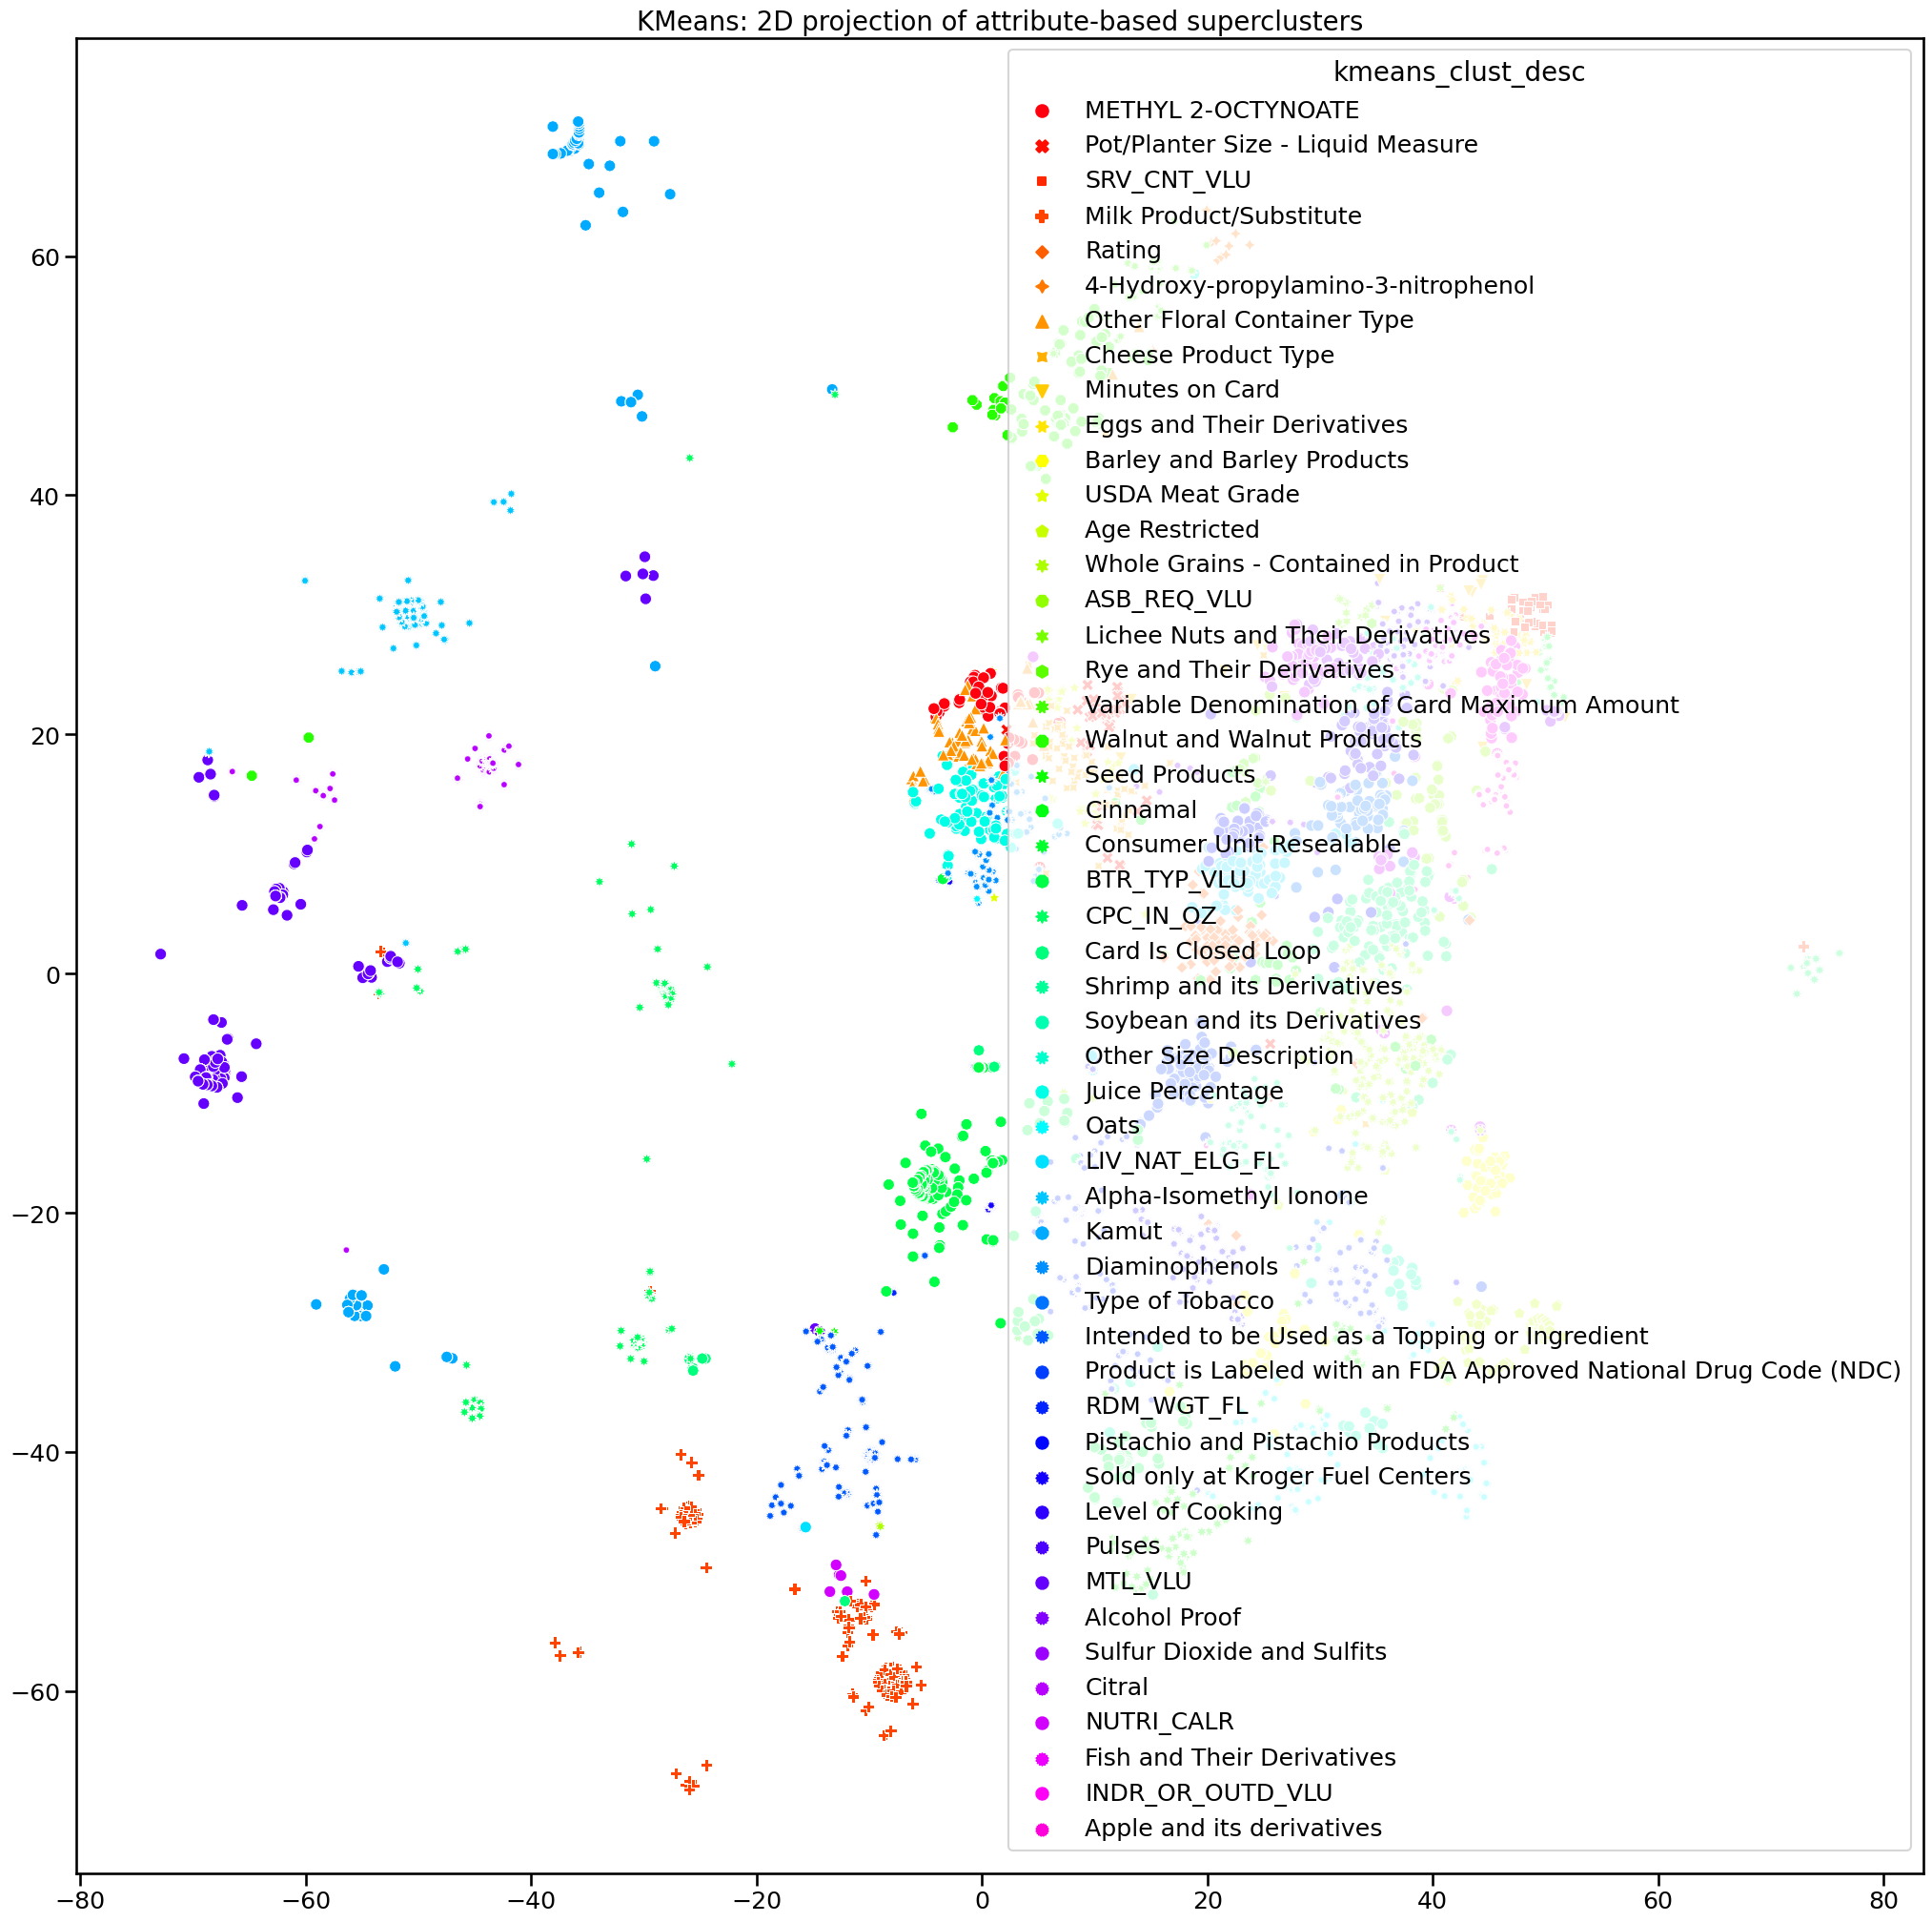

In [86]:
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(25,25))
plt.title('KMeans: 2D projection of attribute-based superclusters')
sns.scatterplot(x=X_embedded.T[0], 
                y=X_embedded.T[1], 
                hue=clust_attr['kmeans_clust_desc'],  
                style=clust_attr['kmeans_clust_desc'],palette = "gist_rainbow",legend= 'full')

In [38]:
import plotly.offline as pyo
import plotly.graph_objs as go
import numpy as np
  
  
# create variableX_embedded.T[0] data which holds the data
data=[go.Scatter(x=X_embedded.T[0],
                 y=X_embedded.T[1],
                 # hue=kmeans.labels_, style=kmeans.labels_,palette = "gist_rainbow",legend= 'full',
                 mode='markers',
                 marker= dict(size= 12,
                               color= 'rgb(51,204,153)',
                               symbol= 'pentagon',
                               line= {'width':2}
                               ) )]
  
# create layout of scatter plot
layout=go.Layout(title='Random Scatter Plot',
                 xaxis= {'title':'X-AXIS'}  ,
                 yaxis= dict(title='Y-AXIS'),
                 hovermode= 'closest' )
# create figure variable to pass the
# data and Layout
fig= go.Figure(data=data , layout=layout)
  
# call plot function using plotly offlin
pyo.plot(fig, filename='scatterplot-1.html')

'scatterplot-1.html'

<Axes: title={'center': 'KMeans: 2D projection of attribute-based superclusters'}>

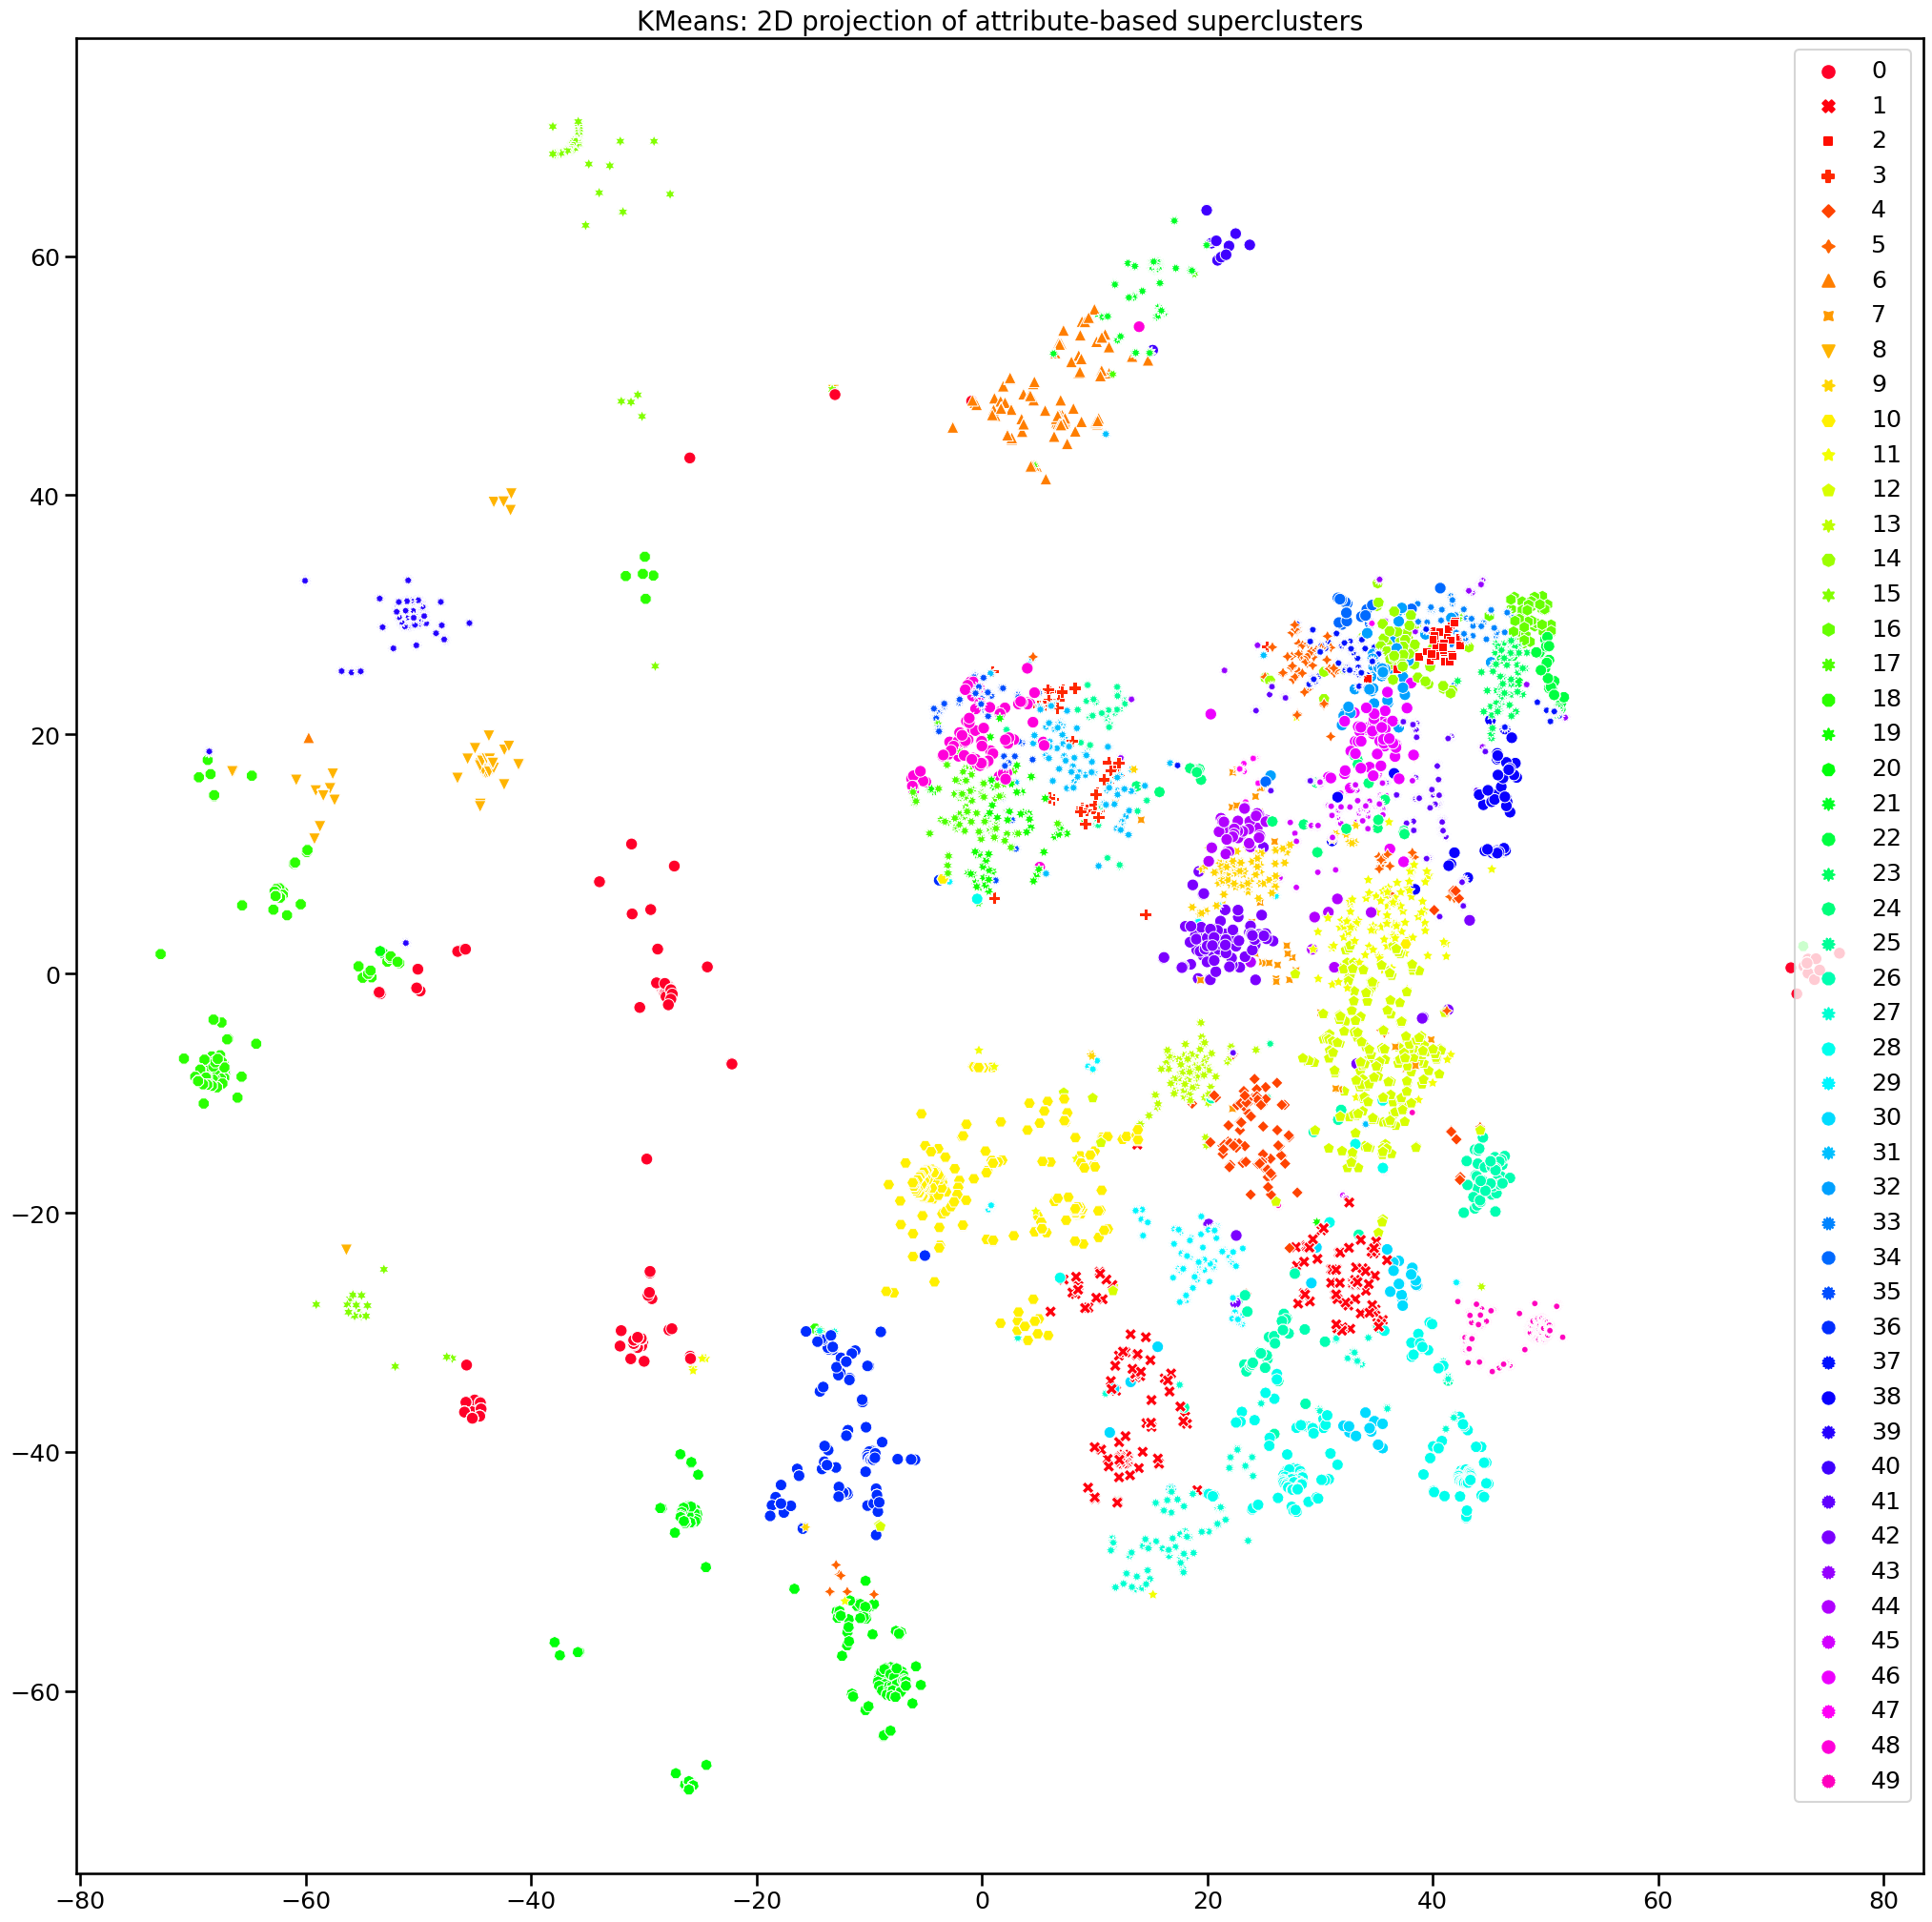

In [67]:
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(25,25))
plt.title('KMeans: 2D projection of attribute-based superclusters')
sns.scatterplot(x=X_embedded.T[0], 
                y=X_embedded.T[1], 
                hue=kmeans.labels_,  style=kmeans.labels_,palette = "gist_rainbow",legend= 'full')

In [462]:
clust_attr[clust_attr['KMeans SuperCluster Label'] == 10].head(50)

ClusterLabel                                       Cluster Name  \
ClusterLabel                                                                    
3                        3                                     CARDS EVERYDAY   
6                        6                          CARDS EVERYDAY,CARD GAMES   
15                      15                      CARDS EVERYDAY,CARDS SEASONAL   
21                      21  CARDS EVERYDAY,CARD EVERYDAY - SONG,CARD EVERY...   
65                      65          GIFT-WRAP EVERYDAY,GIFT-WRAP SEASONAL,NFL   
103                    103                                     CARDS EVERYDAY   
114                    114                CARDS EVERYDAY,CARD EVERYDAY - SONG   
149                    149                           CARDS EVERYDAY,NOVELTIES   
177                    177       CARDS EVERYDAY,CARDS SEASONAL,PARTY EVERYDAY   
199                    199                        CARDS EVERYDAY,FISHER PRICE   
261                    261                                     CARDS EVERYDAY   
272                    272  CHIX: VALUE ADDED (HOT),ENTREES HOT,CHIX:VALUE...   
316                    316        JR DRESSES,JR SS KNIT TOPS,WOVENS,4-16 TOPS   
328                    328    CONSOLE ACCESSORIES,R/C VEHICLES,ACTION FIGURES   
336                    336                                     CARDS SEASONAL   
339                    339                       CARDS EVERYDAY,TRADING CARDS   
344                    344         CARDS EVERYDAY,SPECIAL EVERYDAY,CARD GAMES   
370                    370                     CARDS EVERYDAY,CHILDRENS VALUE   
377                    377                                     CARDS EVERYDAY   
407                    407  CARDS SEASONAL,CARD SEASONAL - SONG,CARD SEASO...   
423                    423  CARDS SEASONAL,CARD SEASONAL - SONG,GIFT-WRAP ...   
428                    428  CARDS EVERYDAY,FLORAL WRAP SUPPLIES,GIFT-WRAP ...   
437                    437                 CARDS SEASONAL,CARD SEASON - VALUE   
440                    440  BASIC HAND TOOLS,DIY ELECTRICAL,BASIC POWER TO...   
445                    445                     CARDS EVERYDAY,SOUVENIRS (SBT)   
492                    492                  CARDS EVERYDAY,GIFT-WRAP EVERYDAY   
495                    495     CARDS EVERYDAY,SPECIAL EVENTS,SPECIAL EVERYDAY   
518                    518                                     CARDS EVERYDAY   
521                    521  CARDS EVERYDAY,SPECIAL EVERYDAY,TRADING CARDS,...   
554                    554                                     CARDS EVERYDAY   
569                    569  CARDS EVERYDAY,CARDS SEASONAL,CARD EVERYDAY - ...   
574                    574                                     CARDS SEASONAL   
575                    575  SCHOOL SUPPLIES,FISHER PRICE,ART & CRAFT SUPPL...   
596                    596                         CARDS EVERYDAY,TRADE BOOKS   
605                    605                                     CARDS EVERYDAY   
651                    651                             CARDS SEASONAL,WATCHES   
652                    652  CARDS SEASONAL,SPECIAL SEASONAL,DVD'S,VALENTIN...   
656                    656  SPECIAL EVERYDAY,SPECIAL SEASONAL,CARDS SEASON...   
659                    659                               POSTERS/STICKERS/ETC   
661                    661  CARDS SEASONAL,GIFT-WRAP EVERYDAY,SEASONAL NOV...   
687                    687  CARDS SEASONAL,CARD SEASONAL - SONG,CARD SEASO...   
692                    692              GIFT-WRAP EVERYDAY,GIFT-WRAP SEASONAL   
749                    749  CARDS SEASONAL,CARD SEASONAL - SONG,CARD SEASO...   
769                    769          WOVENS,WOVEN TOPS,SWEATERS,GIRLS 4-18 DIP   
774                    774  R/C VEHICLES,MODELS,750ML RED LUXURY WINES ABO...   
786                    786  CARDS SEASONAL,CARD SEASONAL - SONG,SPECIAL EV...   
789                    789  CARDS EVERYDAY,CARD EVERYDAY - VALUE,DECORATIV...   
794                    794                   

In [ ]:

import plotly.express as px 
  
# using the iris dataset
df = px.data.iris() 
  
# plotting the scatter chart
fig = px.scatter(df, x="species", y="petal_width") 
  
# showing the plot
fig.show()

<Axes: title={'center': '2D projection of attribute-based superclusters'}>

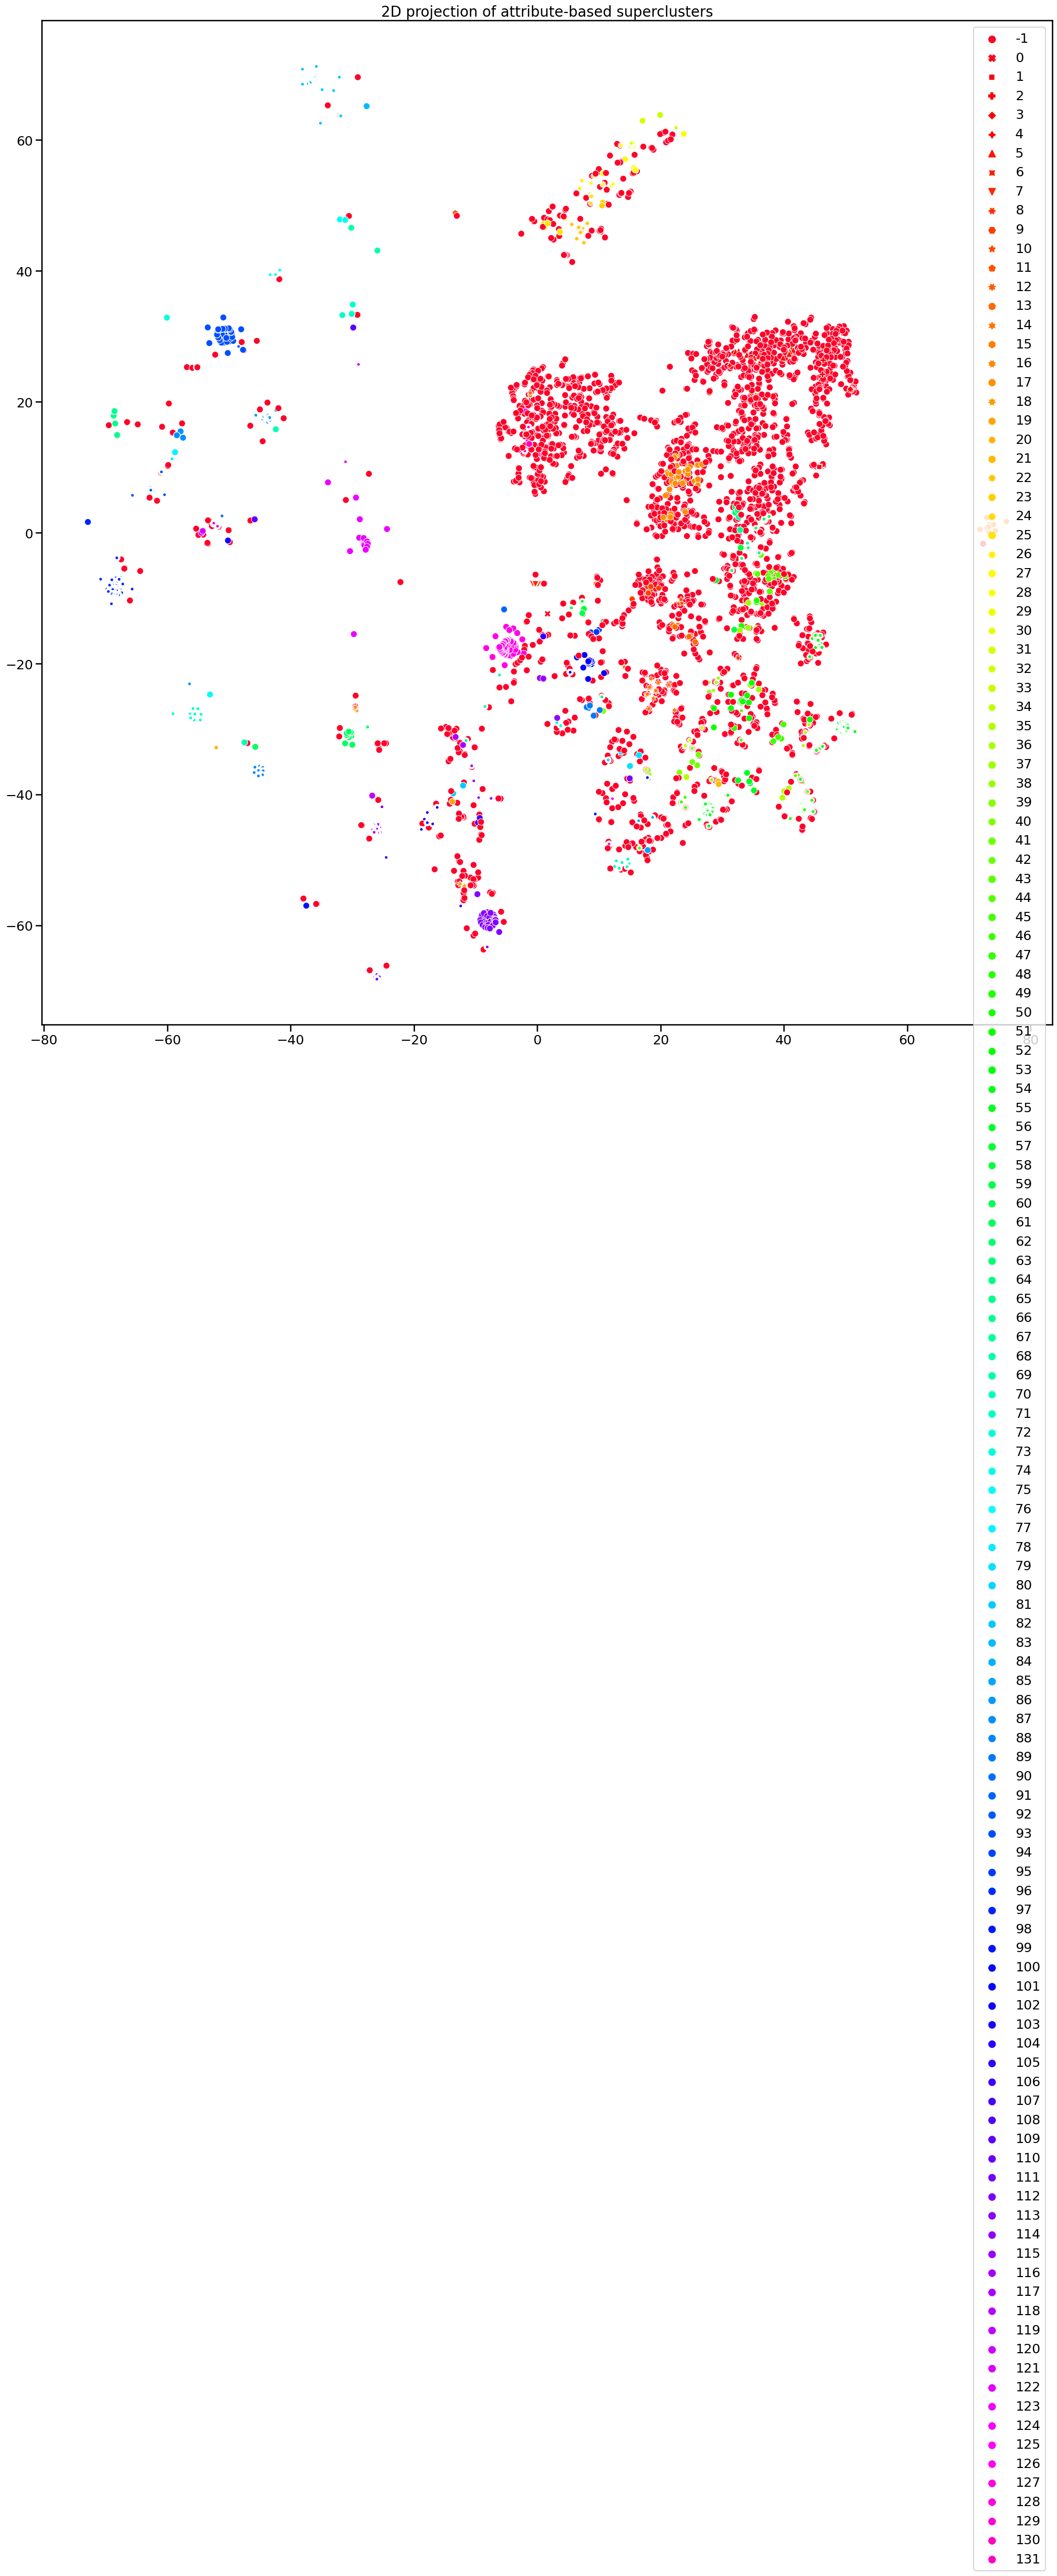

In [69]:
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(25,25))
plt.title('2D projection of attribute-based superclusters')
sns.scatterplot(x=X_embedded.T[0], 
                y=X_embedded.T[1], 
                hue=hdb.labels_,  style=hdb.labels_,palette = "gist_rainbow",legend= 'full')

In [71]:
from datetime import date
dte = date.today().strftime('%m%d%y')
f_name = f'{path}hdb_kmeans_ClusteringResults_{dte}.csv
clust_attr.to_csv(f_name, index = None)

In [3]:
clust_attrx = clust_attr.iloc[0:1]  
clust_attrx.shape 

(1, 4)

In [5]:
clust_attrx.head()

ClusterLabel                                       Cluster Name  \
0             0  PARTY EVERYDAY,NOVELTY AND DECOR,GIFT-WRAP SEA...   

   Cluster Size                                Non-Null Attributes  
0          1306  ['Color', 'Size Description', 'Other Size Desc...

In [6]:
import ast
#y_all_attrbx = set(clust_attrx['Non-Null Attributes'].apply(lambda x: ast.literal_eval(x)))
y_all_attrb1 = clust_attrx['Non-Null Attributes'].apply(lambda x: ast.literal_eval(x))  # pandas.core.series.Series; len = 1

In [11]:
y_all_attrb2

['Color',
 'Size Description',
 'Other Size Description',
 'Other Color',
 'ASBD_ACU_PDT_HGT_IN_INCH',
 'ASBD_ACU_PDT_LTH_IN_INCH',
 'ASBD_ACU_PDT_WTH_IN_INCH',
 'ASB_REQ_VLU',
 'MTL_VLU',
 'VND_BRN_NAM',
 'NET_CONT_EQV_UOM_VIP_TO_KRG_UOM',
 'RDM_WGT_FL',
 'LIV_NAT_ELG_FL',
 'TPT_CLS_VLU',
 'SIZ_QY',
 'SNAP_ELG_FL',
 'TYP_OF_LBL_VLU',
 'ALH_FL',
 'IS_EDBL_VLU',
 'IS_TPCL_VLU',
 'ASBD_ACU_PDT_WGT_IN_LBS',
 'CLX_DSC',
 'INDR_OR_OUTD_VLU',
 'MFR_WTY_LTH_OF_TM_IN_MON',
 'Does Not Contain Declaration Obligatory Allergens']

In [10]:
y_all_attrb2 = clust_attrx['Non-Null Attributes'].apply(lambda x: ast.literal_eval(x)).sum() 

In [12]:
all_attrbs = set(clust_attr['Non-Null Attributes'].apply(lambda x: ast.literal_eval(x)).sum())

## case 2 - row[6]

In [15]:
clust_attry = clust_attr.iloc[[6]]  
clust_attry.head()

ClusterLabel               Cluster Name  Cluster Size  \
6             6  CARDS EVERYDAY,CARD GAMES           909   

                                 Non-Null Attributes  
6  ['VND_BRN_NAM', 'NET_CONT_EQV_UOM_VIP_TO_KRG_U...

In [16]:
type(clust_attry)

pandas.core.frame.DataFrame

In [17]:
y_all_attry2 = clust_attry['Non-Null Attributes'].apply(lambda x: ast.literal_eval(x)).sum() #list

In [19]:
y_all_attry2

['VND_BRN_NAM',
 'NET_CONT_EQV_UOM_VIP_TO_KRG_UOM',
 'NON_GMO_PDT_FL',
 'LIV_NAT_ELG_FL',
 'SIZ_QY',
 'ALH_FL',
 'IS_EDBL_VLU',
 'IS_TPCL_VLU']

## Inter cluster overlap

In [21]:

    clustid_1 = 1 
    clustid_2 = 0
    att1 = set(clust_attr.iloc[clustid_1]['Non-Null Attributes'])
    att2 = set(clust_attr.iloc[clustid_2]['Non-Null Attributes'])
    overlap = att1.intersection(att2)
    len(overlap)/(np.sqrt(len(att1))*np.sqrt(len(att2)))

0.9080536347093006

In [22]:
 att1 

{' ',
 "'",
 ',',
 '-',
 '/',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'y',
 'z'}

In [ ]:
def get_attribute_dict(clust_attrbs):
    return {i: int(i in clust_attrbs) for i in all_attrbs}

In [23]:
clust_attr['Non-Null Attributes'].iloc[200]  #str

"['Genre', 'Color', 'Size Description', 'Other Size Description', 'Other Color', 'In Store Prepared/Packaged', 'Boneless Claim', 'Intended to be Used as a Topping or Ingredient', 'Consumer Lifestage', 'Age Restricted', 'Is Item Intended for Human Consumption?', 'Pot/Planter Size - Liquid Measure', 'Scent', 'ASBD_ACU_PDT_HGT_IN_INCH', 'ASBD_ACU_PDT_LTH_IN_INCH', 'ASBD_ACU_PDT_WTH_IN_INCH', 'ASB_REQ_VLU', 'MTL_VLU', 'VND_BRN_NAM', 'MIN_DAYS_OF_SHF_LIF_AT_WHS_DAYS', 'NET_CONT_EQV_UOM_VIP_TO_KRG_UOM', 'NON_GMO_PDT_FL', 'ORG_CLM_VLU', 'RDM_WGT_FL', 'CER_FOR_POV_DIET_FL', 'LIV_NAT_ELG_FL', 'TPT_CLS_VLU', 'INE_USE_OF_PDT_TX', 'SIZ_QY', 'TYP_OF_LBL_VLU', 'ALH_FL', 'IS_EDBL_VLU', 'IS_TPCL_VLU', 'ASBD_ACU_PDT_WGT_IN_LBS', 'CLX_DSC', 'INDR_OR_OUTD_VLU', 'MFR_WTY_LTH_OF_TM_IN_MON', 'Does Not Contain Declaration Obligatory Allergens']"

In [24]:
type(clust_attr['Non-Null Attributes'].iloc[200])

str

In [24]:
clust_attr[5]

KeyError: 5

In [42]:
clust_attr.iloc[1]['Non-Null Attributes']

"['Genre', 'Color', 'Size Description', 'Other Color', 'In Store Prepared/Packaged', 'Intended to be Used as a Topping or Ingredient', 'Rating', 'Is Item Intended for Human Consumption?', 'Pot/Planter Size - Liquid Measure', 'ASBD_ACU_PDT_HGT_IN_INCH', 'ASBD_ACU_PDT_LTH_IN_INCH', 'ASBD_ACU_PDT_WTH_IN_INCH', 'ASB_REQ_VLU', 'FIN_VLU', 'MTL_VLU', 'VND_BRN_NAM', 'GLU_FRE_CLM_VLU', 'MIN_DAYS_OF_SHF_LIF_AT_WHS_DAYS', 'NET_CONT_EQV_UOM_VIP_TO_KRG_UOM', 'NON_GMO_PDT_FL', 'ORG_CLM_VLU', 'RDM_WGT_FL', 'CER_FOR_POV_DIET_FL', 'LIV_NAT_ELG_FL', 'TPT_CLS_VLU', 'SIZ_QY', 'TYP_OF_LBL_VLU', 'ALH_FL', 'IS_EDBL_VLU', 'IS_TPCL_VLU', 'ASBD_ACU_PDT_WGT_IN_LBS', 'CLX_DSC', 'MFR_WTY_LTH_OF_TM_IN_MON', 'Fish and Their Derivatives', 'Does Not Contain Declaration Obligatory Allergens']"

In [44]:
type(clust_attr.iloc[1][['Non-Null Attributes']])

pandas.core.series.Series

In [45]:
type(clust_attr.iloc[[1]][['Non-Null Attributes']])

pandas.core.frame.DataFrame

In [46]:
type(clust_attr.iloc[[1]]['Non-Null Attributes'])

pandas.core.series.Series

In [48]:
    
    clustid_1 = 0
    clustid_2 = 1
    att1 = set(clust_attr.iloc[[clustid_1]]['Non-Null Attributes'].apply(lambda x: ast.literal_eval(x)).sum())
    att2 = set(clust_attr.iloc[[clustid_2]]['Non-Null Attributes'].apply(lambda x: ast.literal_eval(x)).sum())
    overlap = att1.intersection(att2)
    
    len(overlap)/(np.sqrt(len(att1))*np.sqrt(len(att2)))

0.7437357441610946

In [66]:
clust_attr.columns

Index(['ClusterLabel', 'Cluster Name', 'Cluster Size', 'Non-Null Attributes',
       'AttributeVector', 'hdb_cluster', 'hdb_clust_desc', 'kmeans_cluster',
       'kmeans_clust_desc'],
      dtype='object')

In [ ]:
pd.Series(kmeans.labels_).value_counts(dropna = False).sort_index() 

In [87]:
clust_attr['hdb_cluster'].value_counts(dropna = False).sort_index() 

-1      2784
 0         5
 1         8
 2         7
 3         6
 4         6
 5        32
 6         5
 7        15
 8         6
 9        18
 10        7
 11        6
 12       11
 13       16
 14       31
 15       68
 16       10
 17       61
 18       10
 19       11
 20        8
 21        6
 22       48
 23        8
 24       15
 25       20
 26       13
 27       11
 28       16
 29        6
 30       39
 31       10
 32       29
 33        8
 34       13
 35        7
 36        5
 37       13
 38       11
 39        5
 40        5
 41       12
 42        8
 43       25
 44        5
 45       12
 46        8
 47        5
 48       56
 49        6
 50        5
 51       45
 52       32
 53        7
 54       71
 55       14
 56       70
 57        6
 58       16
 59        5
 60       16
 61       46
 62        9
 63        6
 64        7
 65       32
 66       13
 67        8
 68        5
 69       13
 70       31
 71       26
 72       75
 73       17
 74       19
 75       25